In [ ]:
!kaggle competitions download -c playground-series-s5e2
!kaggle datasets download souradippal/student-bag-price-prediction-dataset

!unzip -u *.zip

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.model_selection import cross_validate

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, TargetEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

KAGGLE_RUN = False
if KAGGLE_RUN:
    working_dir = Path('/kaggle/input/playground-series-s5e2')
else:
    working_dir = Path().cwd()


In [2]:
train_df = pd.concat([
    pd.read_csv(working_dir/'train.csv'),
    pd.read_csv(working_dir/'training_extra.csv')
    ], axis=0, ignore_index=True)

test_df = pd.read_csv(working_dir/'test.csv')

original_df = pd.read_csv(working_dir/'Noisy_Student_Bag_Price_Prediction_Dataset.csv')

train_df

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...,...
3994313,4194313,Nike,Canvas,NaN,3.0,Yes,Yes,Messenger,Blue,28.098120,104.74460
3994314,4194314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531,122.39043
3994315,4194315,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708,148.18470
3994316,4194316,Puma,Canvas,NaN,2.0,No,No,Backpack,Gray,28.783339,22.32269


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 335.2+ MB


In [4]:
CATEGORIC_COLUMNS = ['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
NUMERIC_COLUMNS = ['Weight Capacity (kg)']
TARGET_COLUMN = ['Price']

In [5]:
def get_unique_vals(df:pd.DataFrame, column:str) -> None:
    print(f'{column} has the following unique entries {len(df[column].unique())}')
    print(f'{df[column].value_counts()}')
    print('-----------------------------------')


for column in CATEGORIC_COLUMNS:
    get_unique_vals(train_df, column)


Brand has the following unique entries 6
Brand
Under Armour    801035
Adidas          797000
Nike            764407
Puma            755778
Jansport        749340
Name: count, dtype: int64
-----------------------------------
Material has the following unique entries 5
Material
Polyester    1060882
Leather       976186
Nylon         942656
Canvas        903632
Name: count, dtype: int64
-----------------------------------
Size has the following unique entries 4
Size
Medium    1354487
Large     1312295
Small     1239751
Name: count, dtype: int64
-----------------------------------
Compartments has the following unique entries 10
Compartments
1.0     423577
4.0     417246
2.0     408150
3.0     406796
7.0     400824
5.0     399418
9.0     398192
10.0    396303
8.0     383172
6.0     360640
Name: count, dtype: int64
-----------------------------------
Laptop Compartment has the following unique entries 3
Laptop Compartment
Yes    1972937
No     1922848
Name: count, dtype: int64
-------------

In [6]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3994318.0,2.182137e+06,1.178058e+06,0.0,1.198579e+06,2.197158e+06,3.195738e+06,4194317.0
Compartments,3994318.0,5.434740e+00,2.893043e+00,1.0,3.000000e+00,5.000000e+00,8.000000e+00,10.0
Weight Capacity (kg),3992510.0,1.801042e+01,6.973969e+00,5.0,1.206896e+01,1.805436e+01,2.398751e+01,30.0
Price,3994318.0,8.136217e+01,3.893868e+01,15.0,4.747002e+01,8.098495e+01,1.148550e+02,150.0


<Axes: >

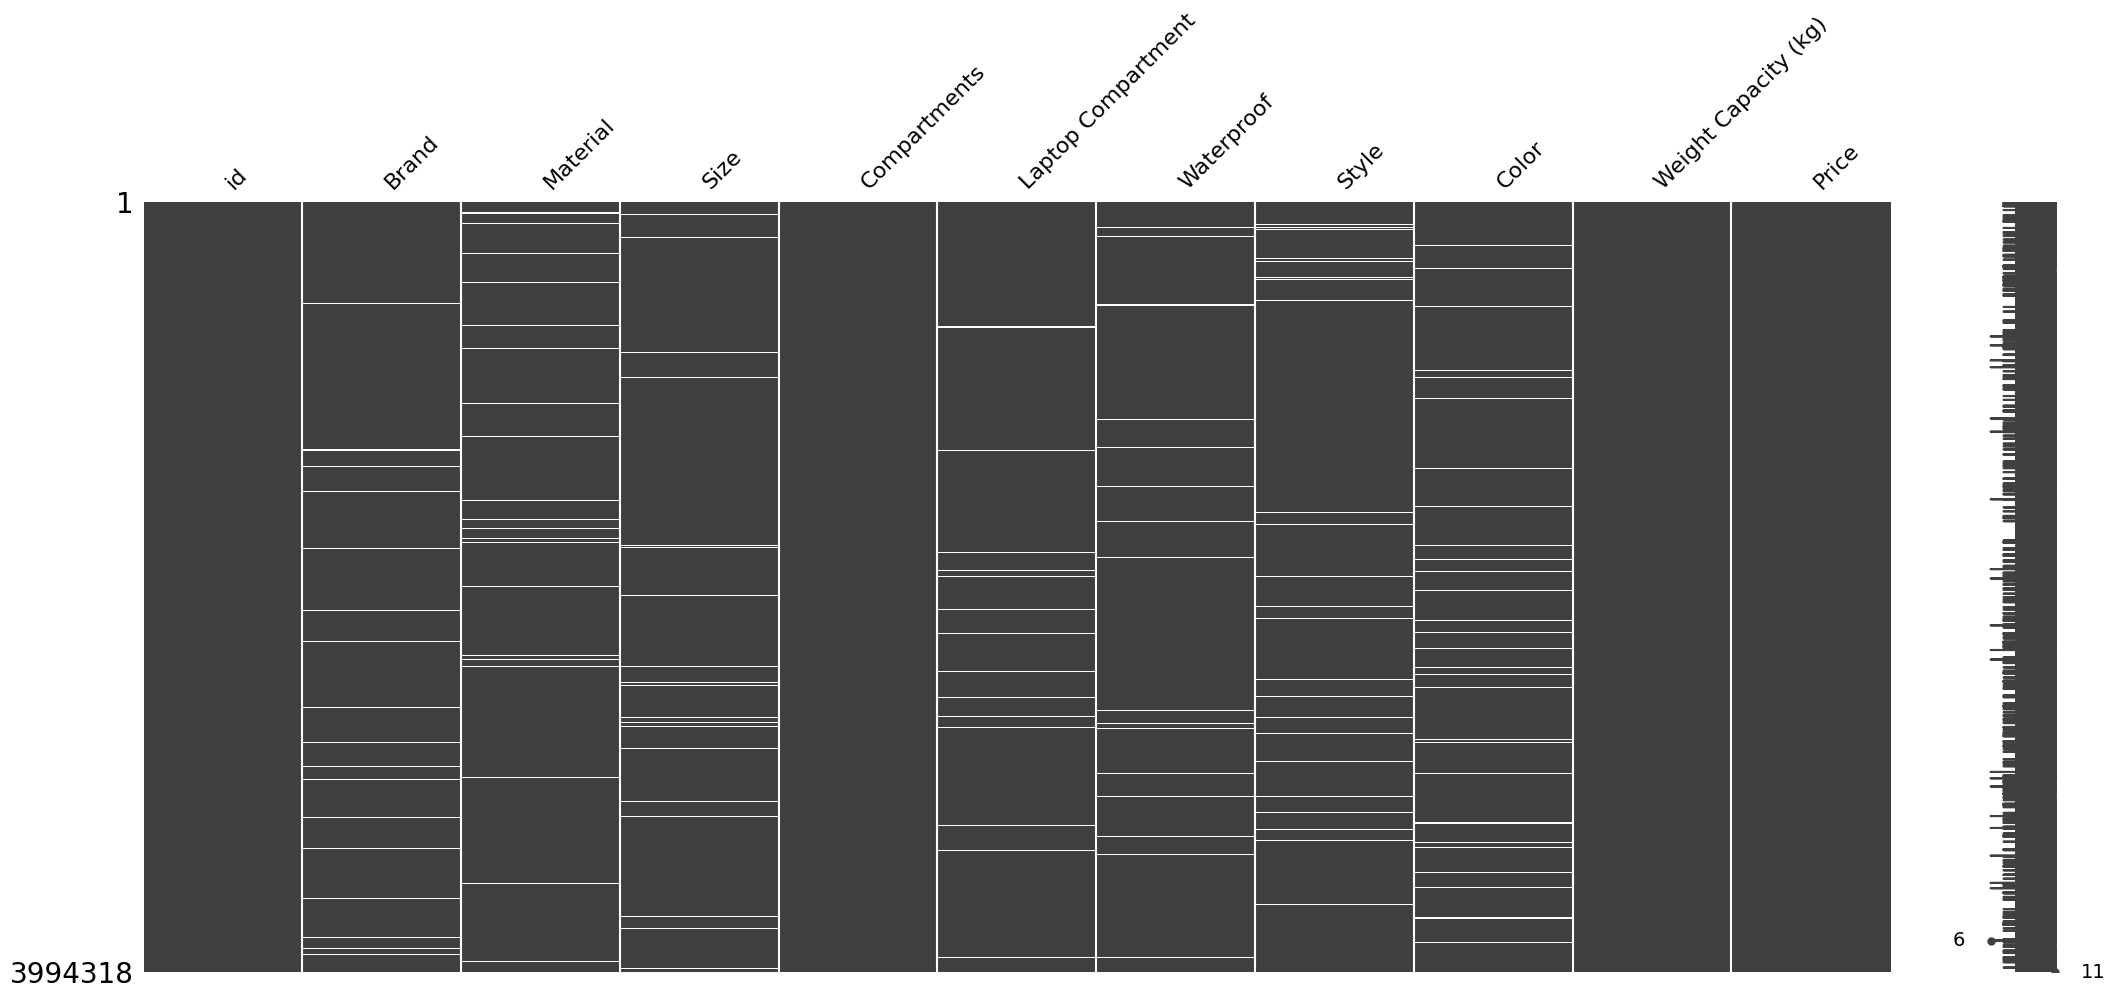

In [7]:
missingno.matrix(train_df)

<Axes: >

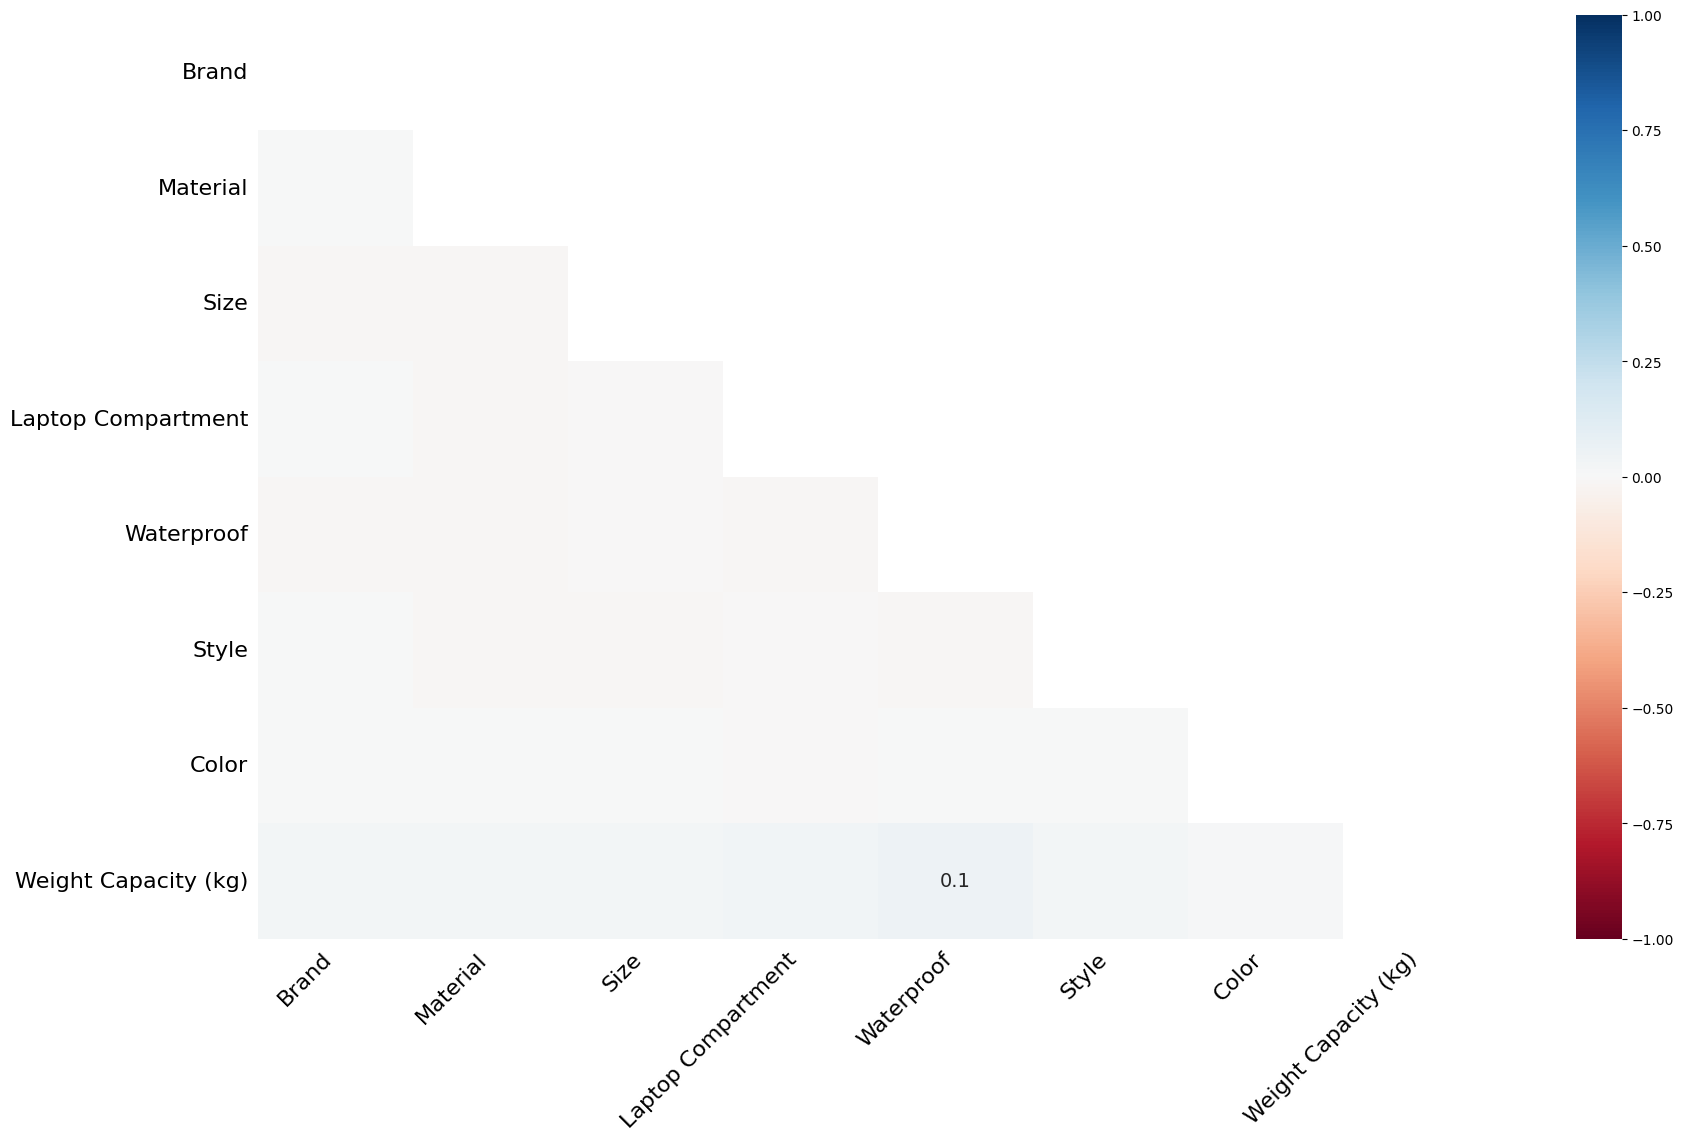

In [8]:
missingno.heatmap(train_df)

In [9]:
missing_values_train = pd.DataFrame({
    'Feature': train_df.columns,
    'No. of Missing Values': train_df.isnull().sum().values,
    '% of Missing Values': ((train_df.isnull().sum().values)/len(train_df)*100)
    })
missing_values_train

,Feature,No. of Missing Values,% of Missing Values
0,id,0,0.000000
1,Brand,126758,3.173458
2,Material,110962,2.777996
3,Size,87785,2.197747
4,Compartments,0,0.000000
5,Laptop Compartment,98533,2.466829
6,Waterproof,94324,2.361454
7,Style,104180,2.608205
8,Color,133617,3.345177
9,Weight Capacity (kg),1808,0.045264


In [14]:
transformer = ColumnTransformer(
    transformers=[
        ('categories', OneHotEncoder(), CATEGORIC_COLUMNS),
        ('weight', MinMaxScaler(), ['Weight Capacity (kg)']),
    ], remainder='passthrough'
)

imputer = KNNImputer(
    n_neighbors=2,
    weights='uniform',
    add_indicator=True,
)

transformer_pipeline=Pipeline(
    steps=[
        ('transform', transformer),
        ('impute', imputer)
    ]
)
imputed_train_df = transformer_pipeline.fit_transform(train_df)
imputed_train_df

In [13]:
missing_values_train = pd.DataFrame({
    'Feature': imputed_train_df.columns,
    'No. of Missing Values': imputed_train_df.isnull().sum().values,
    '% of Missing Values': ((imputed_train_df.isnull().sum().values)/len(imputed_train_df)*100)
    })
missing_values_train

,Feature,No. of Missing Values,% of Missing Values
0,categories__Brand_Adidas,0,0.0
1,categories__Brand_Jansport,0,0.0
2,categories__Brand_Nike,0,0.0
3,categories__Brand_Puma,0,0.0
4,categories__Brand_Under Armour,0,0.0
5,categories__Brand_nan,0,0.0
6,categories__Material_Canvas,0,0.0
7,categories__Material_Leather,0,0.0
8,categories__Material_Nylon,0,0.0
9,categories__Material_Polyester,0,0.0


In [ ]:
train_df.duplicated().sum()

In [ ]:
COMBO = []
for i,column in enumerate(CATEGORIC_COLUMNS):
    #print(f"{c}, ",end="")
    combine = pd.concat([train_df[column],test_df[column]],axis=0)
    combine,_ = pd.factorize(combine)
    train_df[column] = combine[:len(train_df)]
    test_df[column] = combine[len(train_df):]
    new_column = f"{column}_WeightCapacity"
    train_df[new_column] = train_df[column]*100 + train_df["Weight Capacity (kg)"]
    test_df[new_column] = test_df[column]*100 + test_df["Weight Capacity (kg)"]
    COMBO.append(new_column)
print()
print(f"We engineer {len(COMBO)} new columns!")
print( COMBO )

In [ ]:
train_df

In [ ]:
FEATURES = CATEGORIC_COLUMNS + ["Weight Capacity (kg)"] + COMBO
print(f"We now have {len(FEATURES)} columns:")
print( FEATURES )

In [ ]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import xgboost as xgb
print(f"XGBoost version",xgb.__version__)

In [ ]:
# STATISTICS TO AGGEGATE FOR OUR FEATURE GROUPS
STATS = ["mean","std","count","nunique","median","min","max","skew"]
STATS2 = ["mean","std"]

In [ ]:
# %%time

FOLDS = 7
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof = np.zeros((len(train_df)))
pred = np.zeros((len(test_df)))

# OUTER K FOLD
for i, (train_index, test_index) in enumerate(kf.split(train_df)):
    print(f"### OUTER Fold {i+1} ###")

    X_train = train_df.loc[train_index,FEATURES+['Price']].reset_index(drop=True).copy()
    y_train = train_df.loc[train_index,'Price']

    X_valid = train_df.loc[test_index,FEATURES].reset_index(drop=True).copy()
    y_valid = train_df.loc[test_index,'Price']

    X_test = test_df[FEATURES].reset_index(drop=True).copy()

    # INNER K FOLD (TO PREVENT LEAKAGE WHEN USING PRICE)
    kf2 = KFold(n_splits=FOLDS, shuffle=True, random_state=42)   
    for j, (train_index2, test_index2) in enumerate(kf2.split(X_train)):
        print(f" ## INNER Fold {j+1} (outer fold {i+1}) ##")

        X_train2 = X_train.loc[train_index2,FEATURES+['Price']].copy()
        X_valid2 = X_train.loc[test_index2,FEATURES].copy()

        ### FEATURE SET 1 (uses price) ###
        col = "Weight Capacity (kg)"
        tmp = X_train2.groupby(col).Price.agg(STATS)
        tmp.columns = [f"TE1_wc_{s}" for s in STATS]
        X_valid2 = X_valid2.merge(tmp, on=col, how="left")
        for c in tmp.columns:
            X_train.loc[test_index2,c] = X_valid2[c].values

        ### FEATURE SET 2 (uses price) ###
        for col in COMBO:
            tmp = X_train2.groupby(col).Price.agg(STATS2)
            tmp.columns = [f"TE2_{col}_{s}" for s in STATS2]
            X_valid2 = X_valid2.merge(tmp, on=col, how="left")
            for c in tmp.columns:
                X_train.loc[test_index2,c] = X_valid2[c].values

    ### FEATURE SET 1 (uses price) ###
    col = "Weight Capacity (kg)"
    tmp = X_train.groupby(col).Price.agg(STATS)
    tmp.columns = [f"TE1_wc_{s}" for s in STATS]
    X_valid = X_valid.merge(tmp, on=col, how="left")
    X_test = X_test.merge(tmp, on=col, how="left")

    ### FEATURE SET 2 (uses price) ###
    for col in COMBO:
        tmp = X_train.groupby(col).Price.agg(STATS2)
        tmp.columns = [f"TE2_{col}_{s}" for s in STATS2]
        X_valid = X_valid.merge(tmp, on=col, how="left")
        X_test = X_test.merge(tmp, on=col, how="left")

    ### FEATURE SET 3 (does not use price) ###
    for col in CATEGORIC_COLUMNS:
        col2 = "Weight Capacity (kg)"
        tmp = X_train.groupby(col)[col2].agg(STATS2)
        tmp.columns = [f"FE3_{col}_wc_{s}" for s in STATS2]
        X_train = X_train.merge(tmp, on=col, how="left")
        X_valid = X_valid.merge(tmp, on=col, how="left")
        X_test = X_test.merge(tmp, on=col, how="left")

    # CONVERT TO CATEGORIC_COLUMNS SO XGBOOST RECOGNIZES THEM
    X_train[CATEGORIC_COLUMNS] = X_train[CATEGORIC_COLUMNS].astype("category")
    X_valid[CATEGORIC_COLUMNS] = X_valid[CATEGORIC_COLUMNS].astype("category")
    X_test[CATEGORIC_COLUMNS] = X_test[CATEGORIC_COLUMNS].astype("category")

    # DROP PRICE THAT WAS USED FOR TARGET ENCODING
    X_train = X_train.drop(['Price'],axis=1)

    # BUILD MODEL
    model = XGBRegressor(
        max_depth=6,  
        colsample_bytree=0.5, 
        subsample=0.8,  
        n_estimators=10_000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=10,
        early_stopping_rounds=100,
        n_jobs=6
    )
    
    # TRAIN MODEL
    COLS = X_train.columns
    model.fit(
        X_train[COLS], y_train,
        eval_set=[(X_valid[COLS], y_valid)],  
        verbose=300,
    )

    # PREDICT OOF AND TEST
    oof[test_index] = model.predict(X_valid[COLS])
    pred += model.predict(X_test[COLS])

pred /= FOLDS

In [ ]:
# COMPUTE OVERALL CV SCORE
true = train_df.Price.values
s = np.sqrt(np.mean( (oof-true)**2.0 ) )
print(f"=> Overall CV Score = {s}")

In [ ]:
# SAVE OOF TO DISK FOR ENSEMBLES
np.save(f"oof_v1",oof)
print("Saved oof to disk")

In [ ]:
print(f"\nIn total, we used {len(COLS)} features, Wow!\n")
print( list(COLS) )